In [1]:
import sys
import os

CURRENT_DIR = os.path.dirname(os.path.realpath("__file__"))
BASE_DIR = os.path.join(CURRENT_DIR, os.pardir)
OUTPUT_DIR = os.path.join(BASE_DIR, "output")
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")

sys.path.append(BASE_DIR)
sys.path.append(CURRENT_DIR)

from model.model import AdaptationModel, Wizard
from model import utils
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, ttest_rel, wilcoxon, mannwhitneyu

from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting

# sns.set_style()
# sns.set_theme(style = 'whitegrid', palette = 'deep')

plt.style.use("../model/myBmh.mplstyle")

/home/simon/miniforge3/envs/abm/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [2]:
# Utilities
from itertools import product, chain
import pandas as pd
import numpy as np


def calc_col_names(named_shape):
    *prefix, shape = named_shape
    names = [map(str, range(i)) for i in shape]
    return map('_'.join, product(prefix, *names))


def create_flat_columns_df_from_dict_of_numpy(
        named_np: dict[str, np.array],
        n_samples_per_np: int,
):
    flat_nps = [a.reshape(n_samples_per_np, -1) for a in named_np.values()]
    stacked_nps = np.column_stack(flat_nps)
    named_shapes = [(name, arr.shape[1:]) for name, arr in named_np.items()]
    col_names = [*chain.from_iterable(calc_col_names(named_shape) for named_shape in named_shapes)]
    df = pd.DataFrame(stacked_nps, columns=col_names)
    df = df.convert_dtypes()
    return df


    

In [5]:
## Load data

# results = load_results(os.path.join(OUTPUT_DIR, "temporary.tar.gz"))
results = load_results(os.path.join(OUTPUT_DIR, "long.tar.gz"))
experiments, data = results

unique_policies = experiments["policy"].unique()

n_scenarios = data["TotalAdapted"].shape[0]
n_replications = data["TotalAdapted"].shape[1]
n_timesteps = data["TotalAdapted"].shape[2]
n_policies = len(unique_policies)

n_metrics = len(list(data.keys()))

print(f"Analysing {n_scenarios} scenarios, with policies {list(unique_policies)}, {n_replications} replications, {n_timesteps} timesteps")

Analysing 4000 scenarios, with policies ['NoPolicy', 'Info', 'Subsidy', 'Info + Subsidy'], 5 replications, 80 timesteps


In [23]:
# Usefull Dataframes
flat_dict=  {k: v.flatten() for k, v in data.items()}
df_all = pd.DataFrame(np.repeat(experiments.values, n_replications*n_timesteps, axis=0), columns=experiments.columns)
df_all["time"]= np.array([i for j in range(n_replications * n_scenarios)  for i in range(n_timesteps)])
df_all = df_all.join(pd.DataFrame(flat_dict))

# Mean of the scenarios
df_scenario_mean = df_all.groupby(["policy", "scenario", "time"])[["TotalAdapted"]].mean()

# df_all = df_all[df_all["avg_savings_per_step_vs_house"] > 0.25]
df_all = df_all[df_all["scenario"] == 1]
df_all.head()

,avg_risk_aversion,avg_savings_per_step_vs_house,avg_trustworthiness_government,max_initial_savings,width_risk_aversion,scenario,policy,model,time,InformationAbundance,SocietalRisk,AverageRiskAversion,AverageEstimationFactor,TotalAdapted
400,0.63337,0.263894,-0.031648,159.27782,0.943702,1,NoPolicy,AdaptationModel,0,0.1,NaN,0.475995,0.510686,0
401,0.63337,0.263894,-0.031648,159.27782,0.943702,1,NoPolicy,AdaptationModel,1,0.1,0.093487,0.466694,0.509275,27
402,0.63337,0.263894,-0.031648,159.27782,0.943702,1,NoPolicy,AdaptationModel,2,0.1,0.076178,0.461975,0.507871,38
403,0.63337,0.263894,-0.031648,159.27782,0.943702,1,NoPolicy,AdaptationModel,3,0.1,0.071818,0.458483,0.506461,41
404,0.63337,0.263894,-0.031648,159.27782,0.943702,1,NoPolicy,AdaptationModel,4,0.1,0.063842,0.455960,0.505183,43


<Axes: xlabel='policy', ylabel='TotalAdapted'>

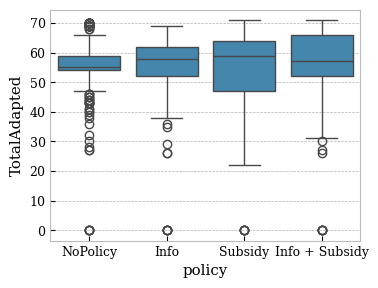

In [25]:
# sns.boxplot(x="policy", y="TotalAdapted", hue="scenario", data=df_all)
sns.boxplot(x="policy", y="TotalAdapted", data=df_all)

Statistics=80035.5, p=0.9914411119267752


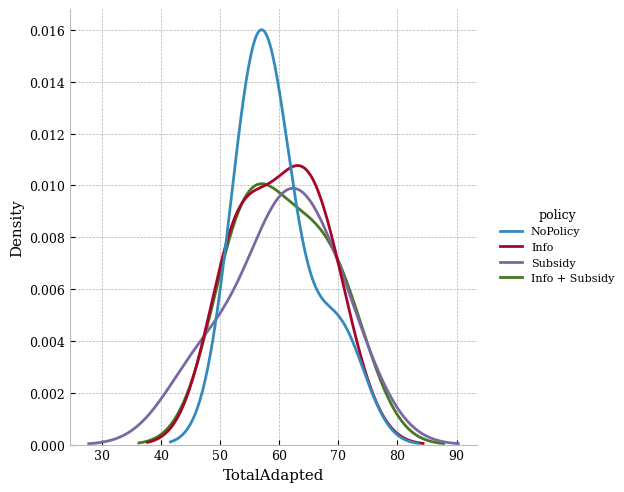

In [26]:
tf = df_all["time"].max()
df_end = df_all[df_all["time"] == tf]
sns.displot(data=df_end, x="TotalAdapted", hue="policy", kind="kde")

stat, p = mannwhitneyu(df_all[df_all["policy"] == "Info"]["TotalAdapted"], df_all[df_all["policy"] == "Subsidy"]["TotalAdapted"])
# stat, p = ttest_ind(df_end[df_all["policy"] == "Info"]["TotalAdapted"], df_end[df_all["policy"] == "Subsidy"]["TotalAdapted"])

print(f"Statistics={stat}, p={p}")

<Axes: xlabel='time', ylabel='TotalAdapted'>

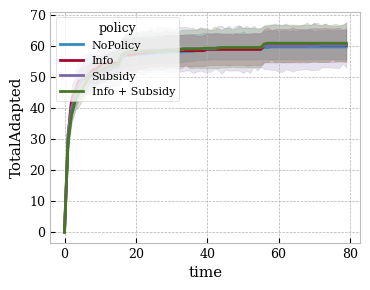

In [27]:
sns.lineplot(data=df_all, x="time", y="TotalAdapted", hue="policy")



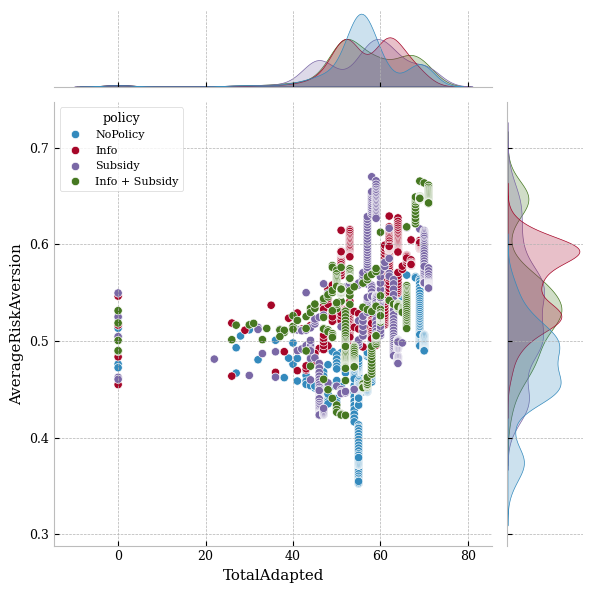

In [28]:
sns.jointplot(data=df_all, x="TotalAdapted", y="AverageRiskAversion", hue="policy")

<Axes: xlabel='time', ylabel='SocietalRisk'>

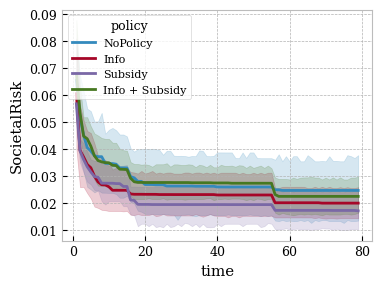

In [29]:
sns.lineplot(data=df_all, x="time", y="SocietalRisk", hue="policy")


<Axes: xlabel='time', ylabel='InformationAbundance'>

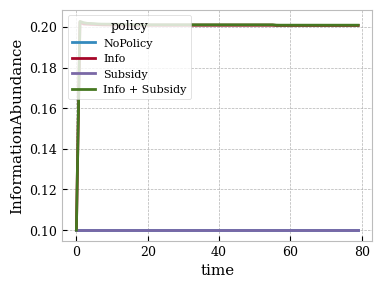

In [30]:
sns.lineplot(data=df_all, x="time", y="InformationAbundance", hue="policy")

<Axes: xlabel='policy', ylabel='TotalAdapted'>

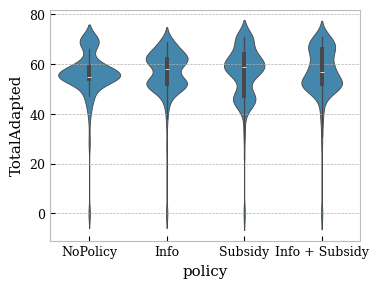

In [31]:
sns.violinplot(data=df_all, x="policy", y="TotalAdapted")

States=149896.0, p=1.7401628070508896e-101


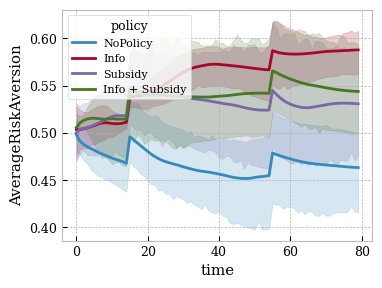

In [32]:
sns.lineplot(data=df_all, x="time", y="AverageRiskAversion", hue="policy")


stat, p = mannwhitneyu(df_all[df_all["policy"] == "Info"]["AverageRiskAversion"], df_all[df_all["policy"] == "NoPolicy"]["AverageRiskAversion"])
print(f"States={stat}, p={p}")

<Axes: xlabel='time', ylabel='AverageEstimationFactor'>

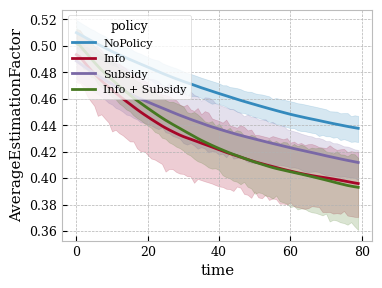

In [33]:
sns.lineplot(data=df_all, x="time", y="AverageEstimationFactor", hue="policy")